In [1]:
import sys
sys.path.append("/n/fs/xl-diffbia/projects/stable-diffusion")

In [2]:
import os
import cv2
from PIL import Image
import copy
import math
import argparse
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import clip
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from domain_classifier.gender import DOMAINS
from occupations.utils import train_list, test_list

/n/fs/xl-diffbia/software/anaconda3/envs/latent-diffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class TxtImg_Gender_Show(datasets.ImageFolder):
    def __init__(
        self, 
        transform, 
        transform_show,
        target_transform,
        cfg_w
    ):
        root = os.path.join("../logs/samples", f"guide_w{cfg_w}")
        super().__init__(root, transform, target_transform)
        self.transform_show = transform_show

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
    
        Returns:
            tuple: (sample_show, sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform_show is not None:
            sample_show = self.transform_show(sample)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample_show, sample, target

In [4]:
# constant
job_list = train_list + test_list
job_list.sort()
print(job_list)

['Accountant', 'Actor', 'Architect', 'Astronaut', 'Audiologist', 'Author', 'Baker', 'Barber', 'Biologist', 'Blacksmith', 'Bricklayer', 'Bus Driver', 'Butcher', 'Carpenter', 'Chef', 'Chemist', 'Civil Engineer', 'Cleaner', 'Clerk', 'Coach', 'Comedian', 'Computer Programmer', 'Construction Worker', 'Consultant', 'Counselor', 'DJ', 'Dancer', 'Dentist', 'Designer', 'Detective', 'Dietitian', 'Doctor', 'Driver', 'Economist', 'Editor', 'Electrician', 'Engineer', 'Entrepreneur', 'Farmer', 'Firefighter', 'Florist', 'Graphic Designer', 'Hairdresser', 'Historian', 'Interpreter', 'Journalist', 'Judge', 'Lawyer', 'Librarian', 'Magician', 'Makeup Artist', 'Manager', 'Marine Biologist', 'Mathematician', 'Mechanic', 'Model', 'Musician', 'Nanny', 'Nurse', 'Nutritionist', 'Optician', 'Painter', 'Paramedic', 'Pastry Chef', 'Pediatrician', 'Pharmacist', 'Photographer', 'Physicist', 'Pilot', 'Plumber', 'Police Officer', 'Politician', 'Professor', 'Psychologist', 'Real Estate Agent', 'Receptionist', 'Recruit

In [5]:
def show_image_row(image_batch, label_index, nmax=4):
    plt.close() # close previous plot
    fig, ax = plt.subplots(figsize=(16, 16 * nmax))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((image_batch.detach()[:nmax]), nrow=nmax).permute(1, 2, 0))
    if label_index is not None:
        plt.title(f"Text prompt: A photo of a single {job_list[label_index]} standing in the center.")
    plt.show()

In [6]:
def show_bar_row(prob_dict, nmax=4):
    plt.close() # close previous plot
    plt.figure(figsize=(4 * nmax, 4))
    
    for idx in range(nmax):
        plt.subplot(1, nmax, idx + 1)
        x_axis = np.arange(2)
        y_axis = np.array([prob_dict[idx][0], prob_dict[idx][1]], dtype=float)
        plt.bar(x_axis, y_axis)
        plt.xticks(x_axis, DOMAINS)
        plt.xlabel("gender", fontsize=14)
        plt.ylim(0, 1.01)
        if idx == 0:
            plt.ylabel("probability", fontsize=14)

    plt.show()

In [7]:
transform_show = transforms.Compose(
                        [
                            transforms.Resize(size=224, interpolation="bicubic", max_size=None, antialias=None),
                            transforms.CenterCrop(size=(224, 224)),
                            transforms.PILToTensor()
                        ]
                    )
transform_show = transforms.PILToTensor() # resolution = 512

In [8]:
def clip_predict(batch_size, cfg_w, num_datapoint=50):
    # Load the model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load('ViT-B/32', device)

    # prepare data
    txtimg_gen_dataset = TxtImg_Gender_Show(transform = preprocess, transform_show = transform_show, target_transform = None, cfg_w = cfg_w)
    txtimg_gen_dataloader = DataLoader(txtimg_gen_dataset, batch_size = batch_size, shuffle=True, num_workers=4)
    domain_text = torch.cat([clip.tokenize(f"a photo of a {domain}") for domain in DOMAINS]) # num_labels x token_length

    # count
    num_show = 0
    true_labels, pred_labels = [], []

    for image_show, image, class_label in iter(txtimg_gen_dataloader):
        # Calculate features
        with torch.no_grad():
            # discrete domain classification
            logits_per_image, logits_per_text = model(image.to(device), domain_text.to(device))
            probs = logits_per_image.softmax(dim=-1).cpu().numpy() # batch_size x num_domains
            syn_pred_value = np.argmax(probs, axis=-1)
            pred_labels.append(syn_pred_value)

            # similarity distance metric
            # image_features = model.encode_image(image.to(device))
            # text_features = model.encode_text(domain_text.to(device))
            # image_features /= image_features.norm(dim=-1, keepdim=True)
            # text_features /= text_features.norm(dim=-1, keepdim=True)
            # similarity = (image_features @ text_features.T)
            
        # visualize
        # assert len(set(class_label.detach().cpu().numpy())) == 1, "image batch not from the same conditioning prompt"
        if len(set(class_label.detach().cpu().numpy())) == 1:
            show_image_row(image_show, class_label.detach().cpu().numpy()[0], nmax=10) # visualize: all images are from same prompt
        else:
            show_image_row(image_show, None, nmax=10)

        # collect human evaluation
        for idx in range(batch_size):
            human_value = int(input("What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure."))
            true_labels.append(human_value)

        # show automatic predictions
        show_bar_row(probs, nmax=10)

        num_show += batch_size
        if num_show >= num_datapoint:
            break
            
    pred_labels = np.concatenate(pred_labels)
    true_labels = np.array(true_labels)

    return pred_labels, true_labels

In [9]:
def plot_cfmx(prediction, truth, cf_title):
    cf_matrix = confusion_matrix(truth, prediction)
    if sum(truth == 2) > 0:
        cf_display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=["female", "male", "unsure"])
    else:
        cf_display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=["female", "male"])
    cf_display.plot()
    plt.title(cf_title)
    plt.show()

### cfg_w = 4.0

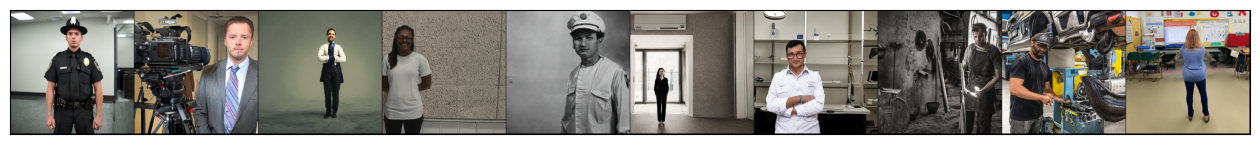

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0


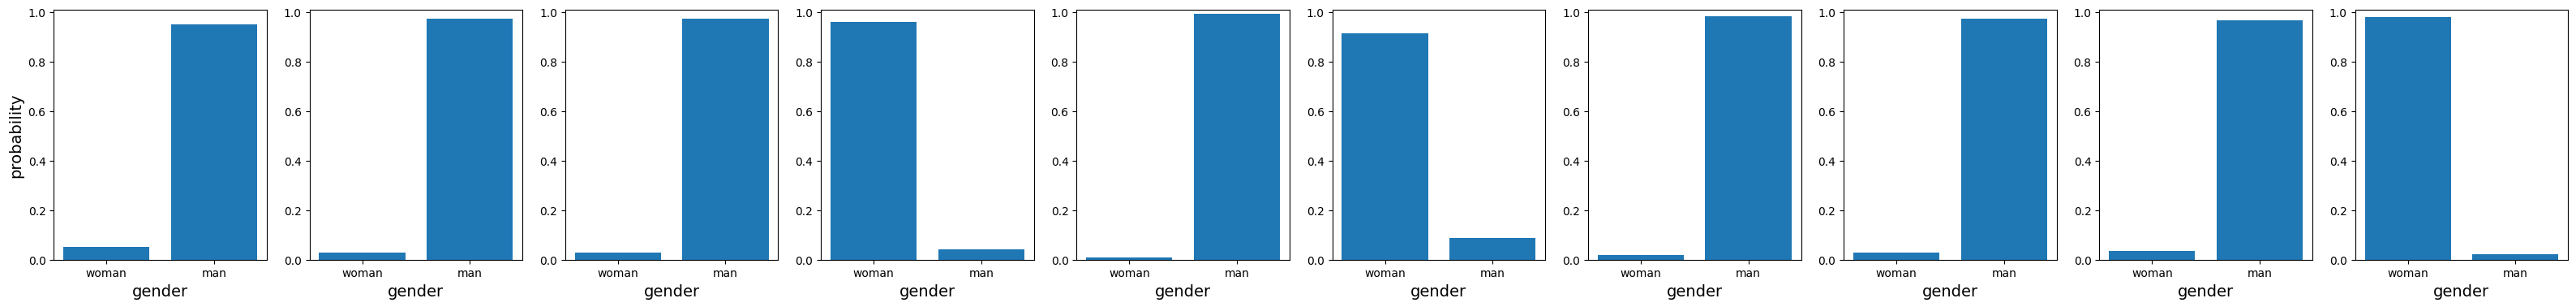

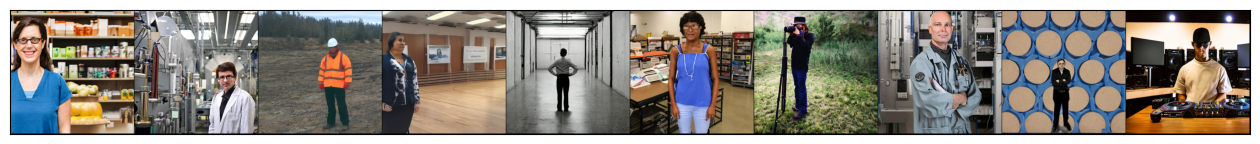

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1


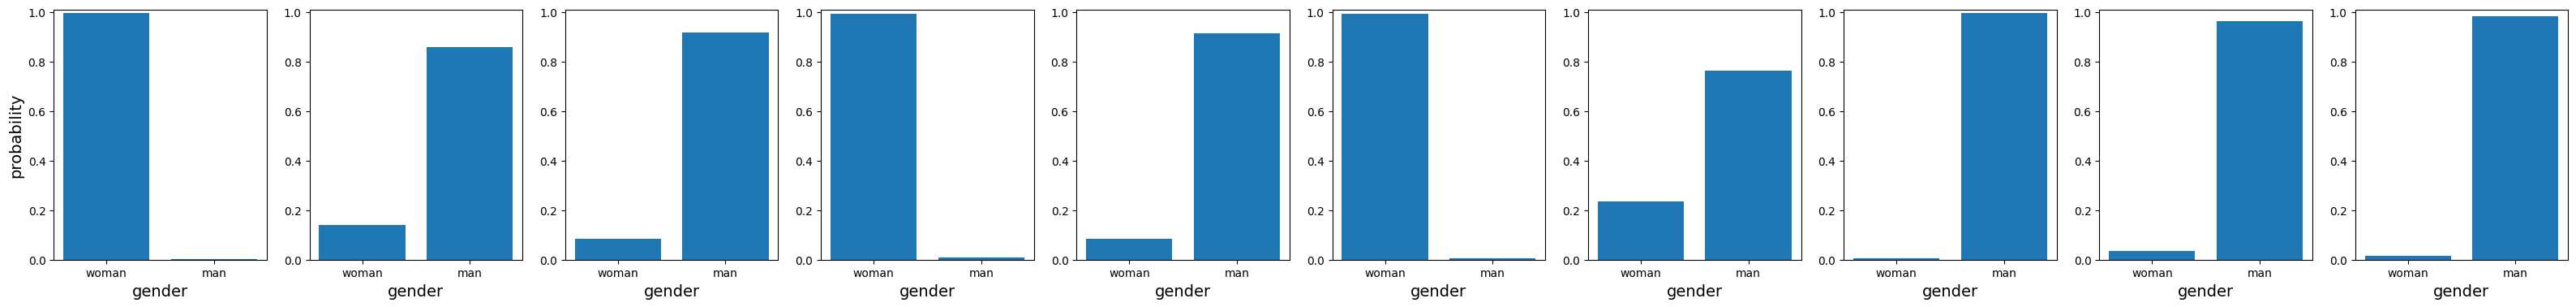

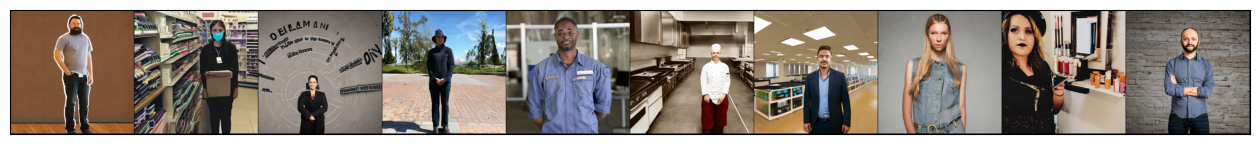

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1


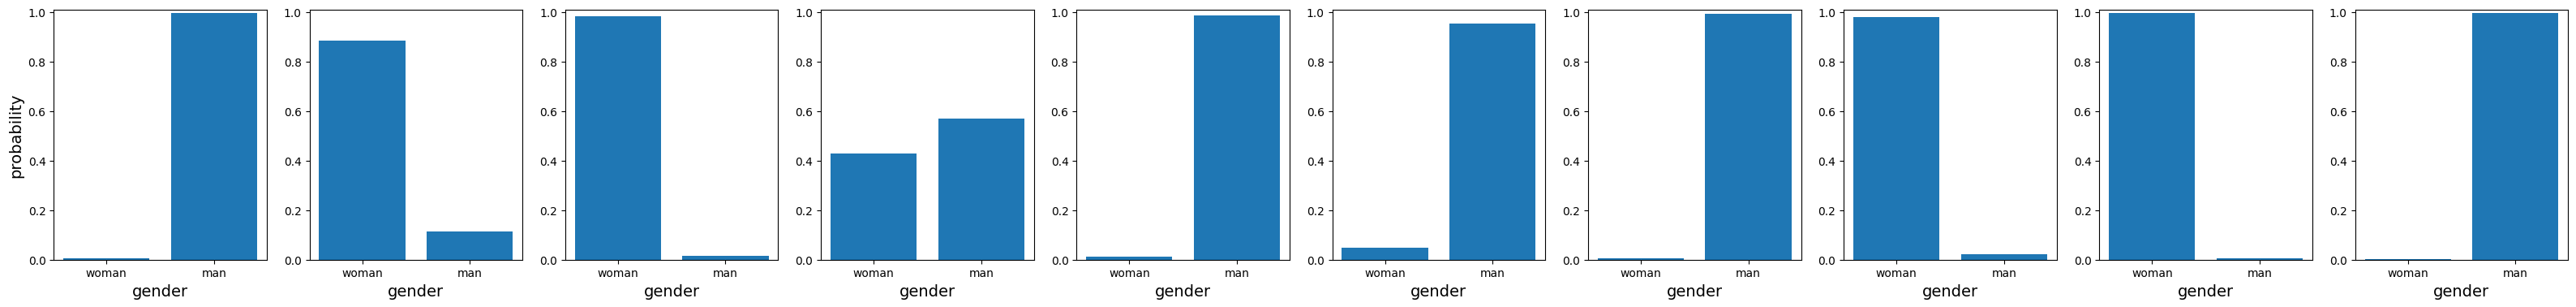

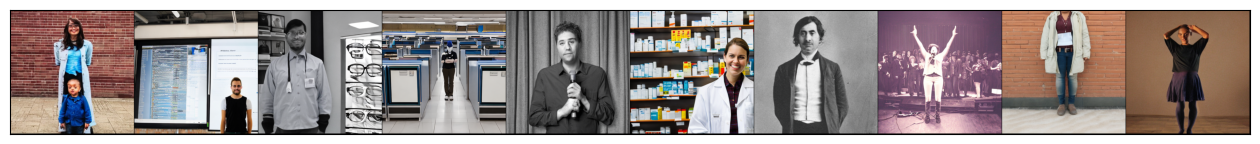

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 2
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0


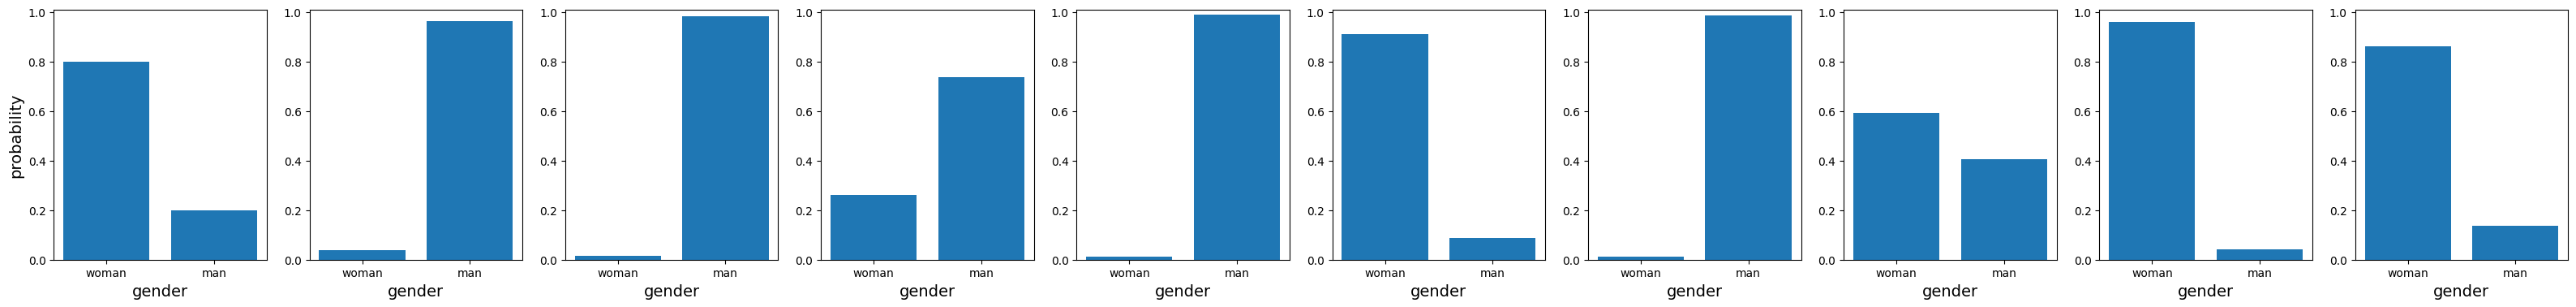

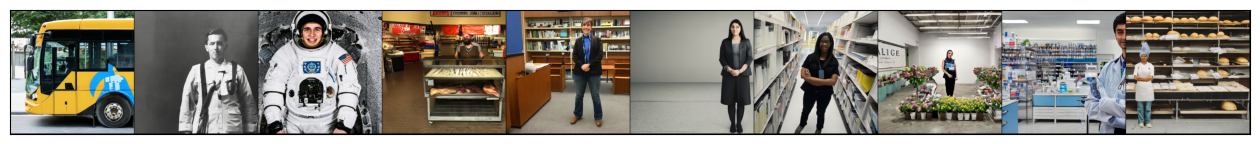

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 2
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 2
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0


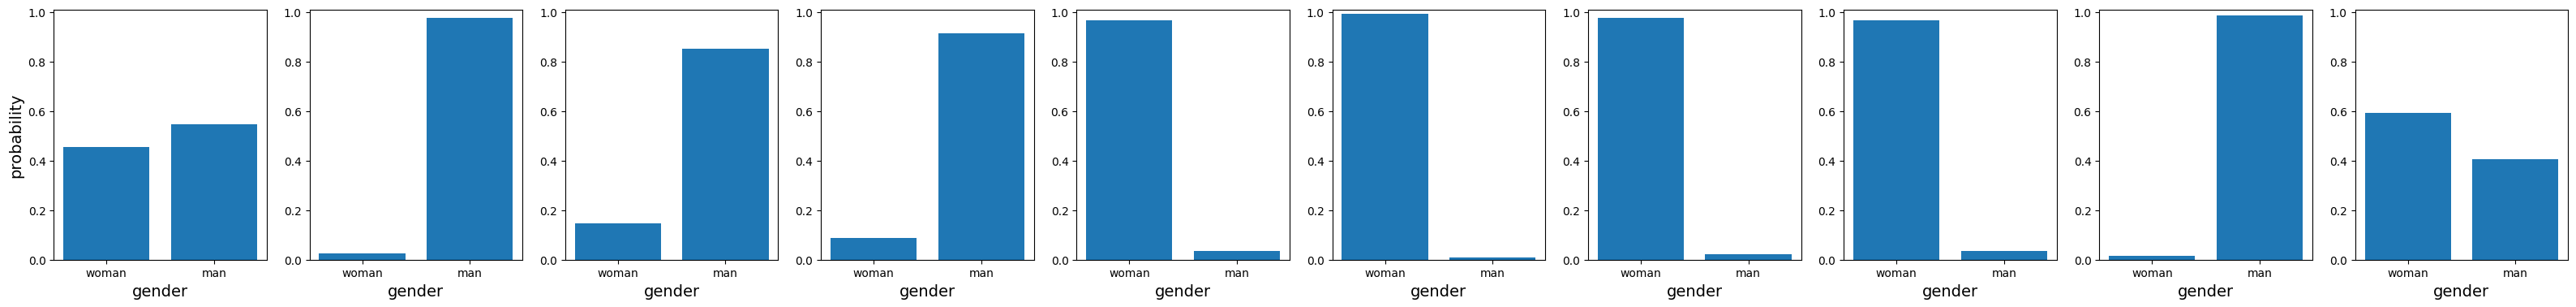

In [10]:
batch_size = 10
cfg_w = 4.0
pred_labels, true_labels = clip_predict(batch_size, cfg_w)

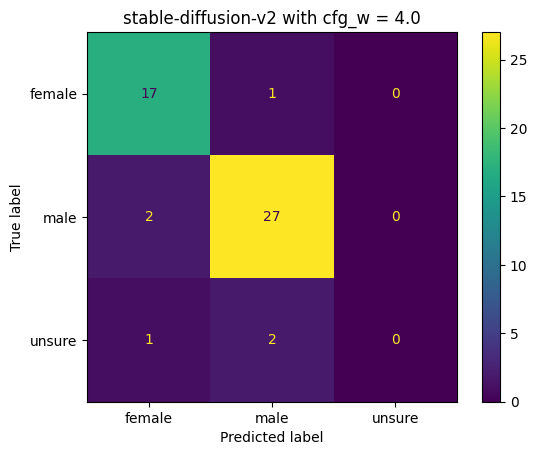

number of automatic classifier predict to be female: 20
number of human perceived annotate to be female: 18
number of human perceived annotate to be unsure: 3


In [11]:
# confusion matrix
plot_cfmx(pred_labels, true_labels, cf_title=f"stable-diffusion-v2 with cfg_w = {cfg_w}")

# consistency at representation level: number of predicted female and numer of labeled female
print(f"number of automatic classifier predict to be female: {sum(pred_labels == 0)}")
print(f"number of human perceived annotate to be female: {sum(true_labels == 0)}")
print(f"number of human perceived annotate to be unsure: {sum(true_labels == 2)}")

### cfg_w = 12.0

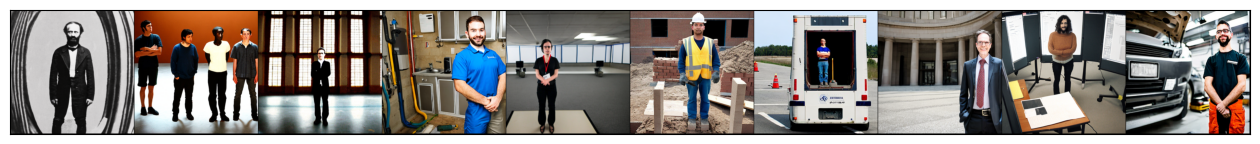

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1


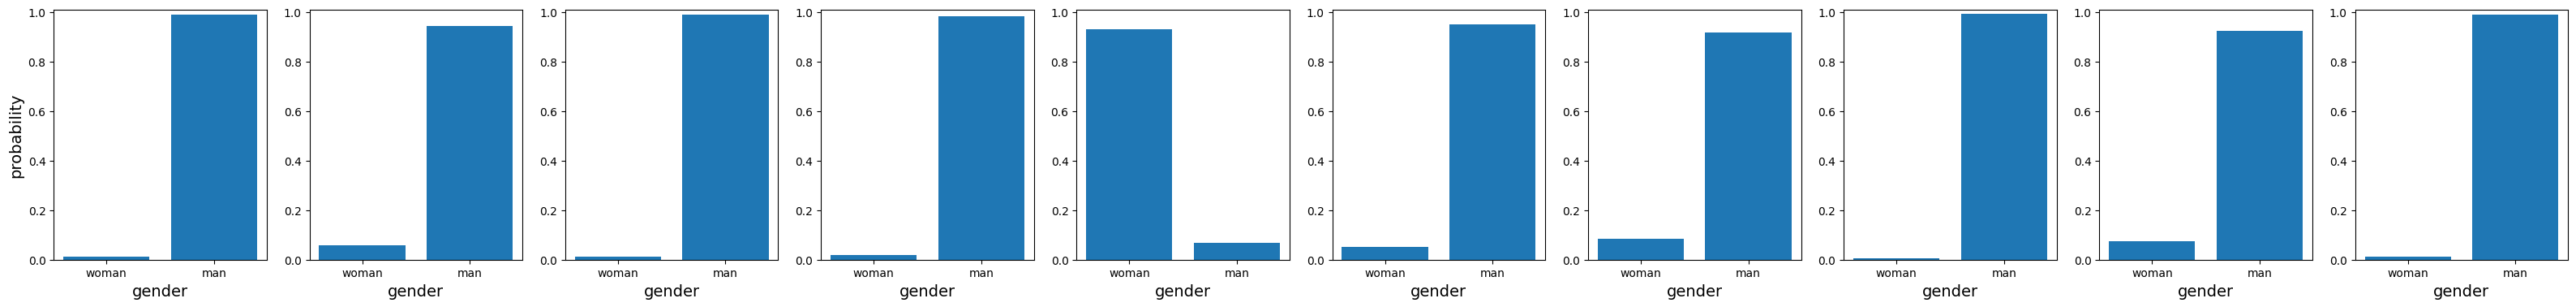

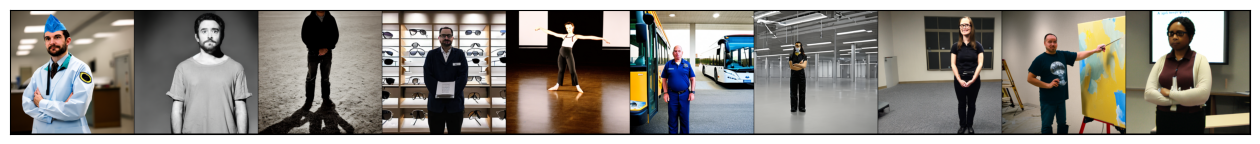

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 2
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0


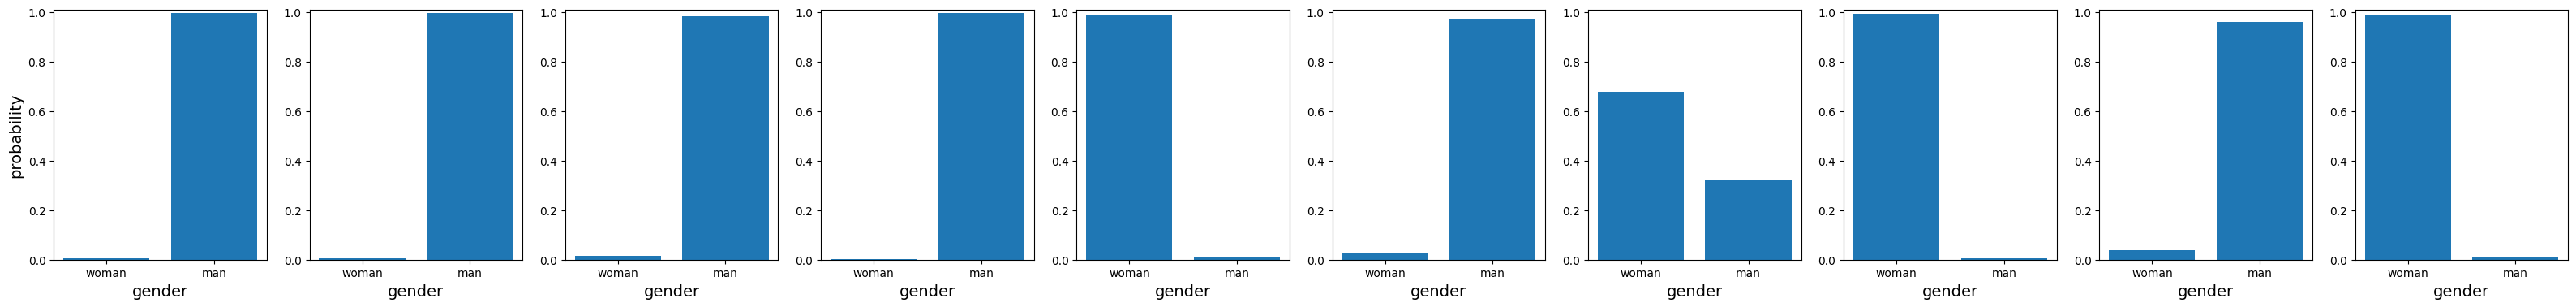

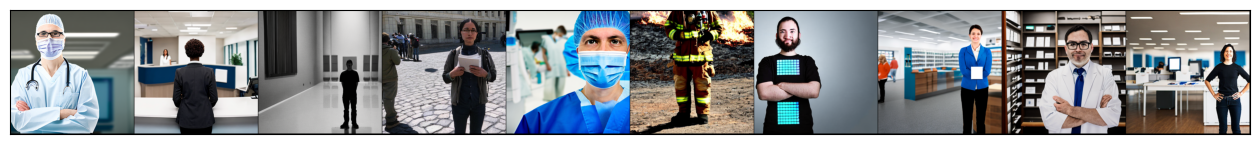

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 2
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 2
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0


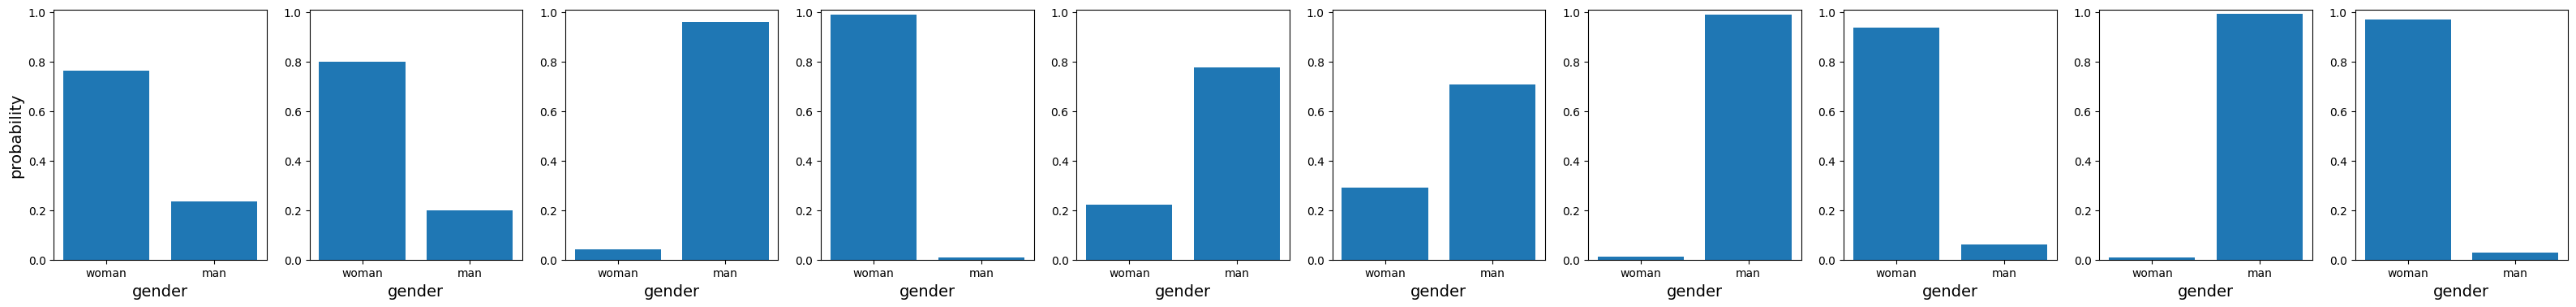

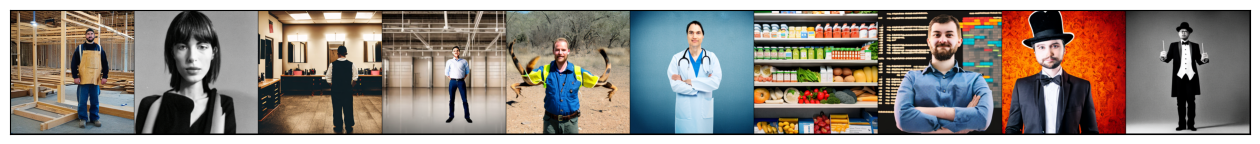

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 2
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1


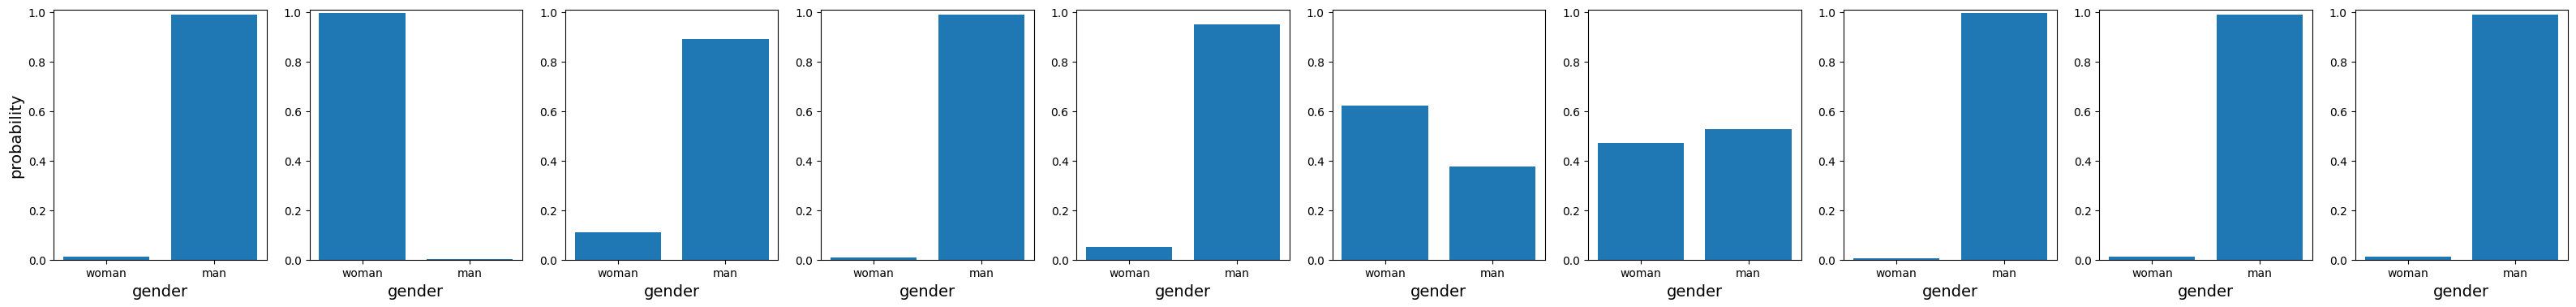

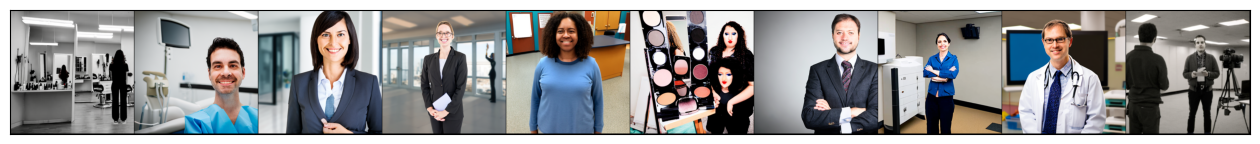

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1


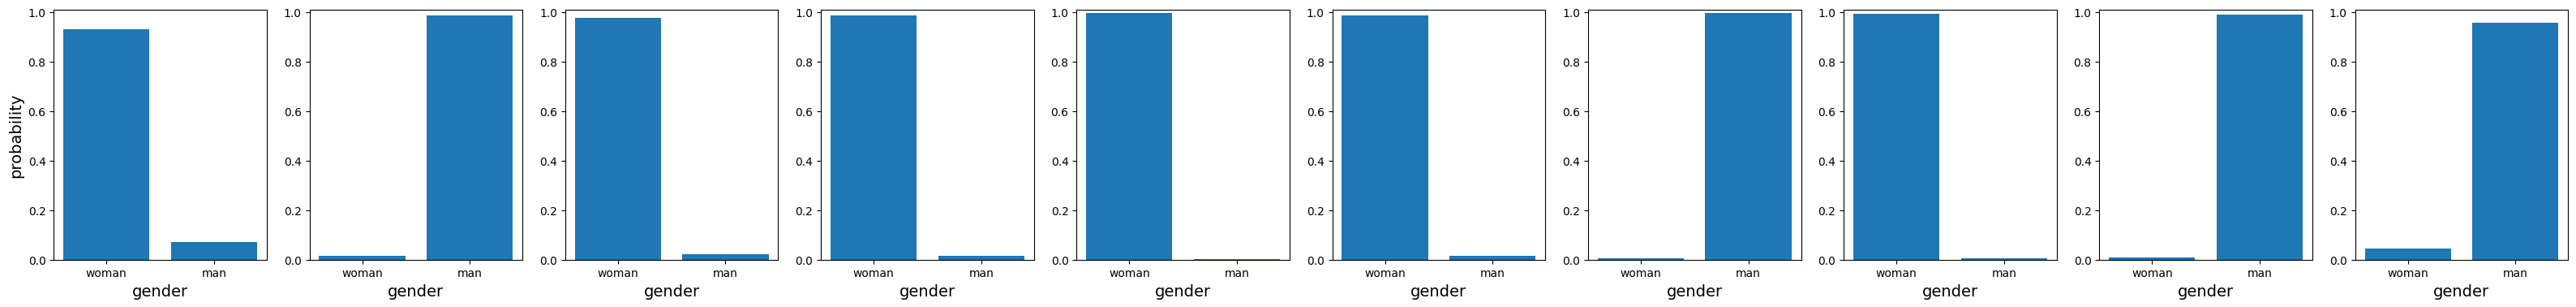

In [12]:
batch_size = 10
cfg_w = 12.0
pred_labels, true_labels = clip_predict(batch_size, cfg_w)

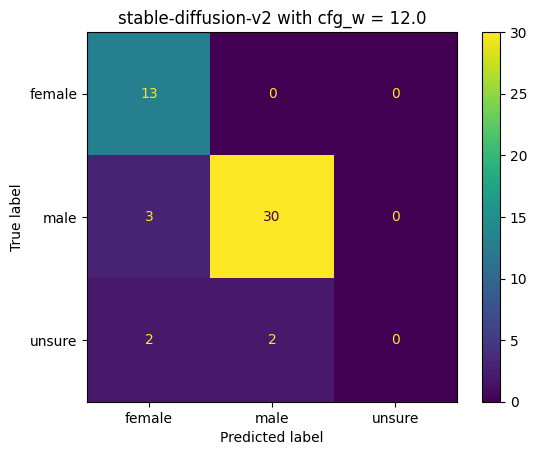

number of automatic classifier predict to be female: 18
number of human perceived annotate to be female: 13
number of human perceived annotate to be unsure: 4


In [13]:
# confusion matrix
plot_cfmx(pred_labels, true_labels, cf_title=f"stable-diffusion-v2 with cfg_w = {cfg_w}")

# consistency at representation level: number of predicted female and numer of labeled female
print(f"number of automatic classifier predict to be female: {sum(pred_labels == 0)}")
print(f"number of human perceived annotate to be female: {sum(true_labels == 0)}")
print(f"number of human perceived annotate to be unsure: {sum(true_labels == 2)}")

### cfg_w = 20.0

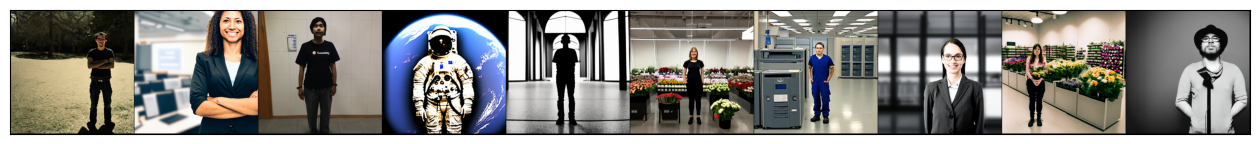

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 2
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1


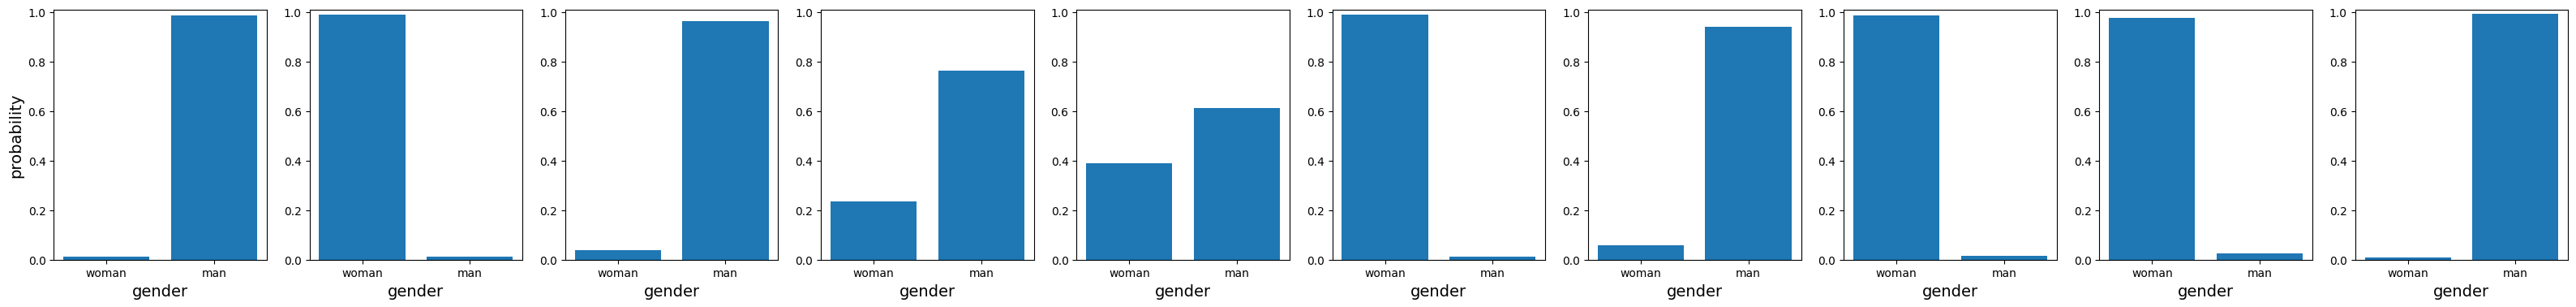

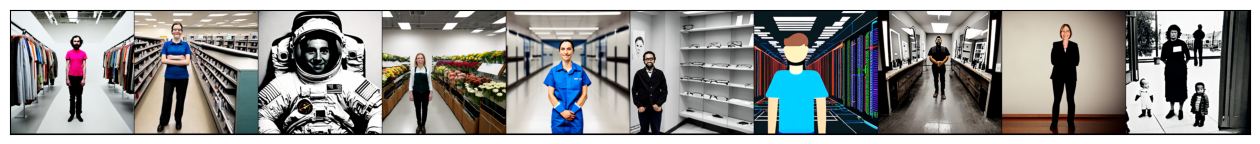

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 2
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 2


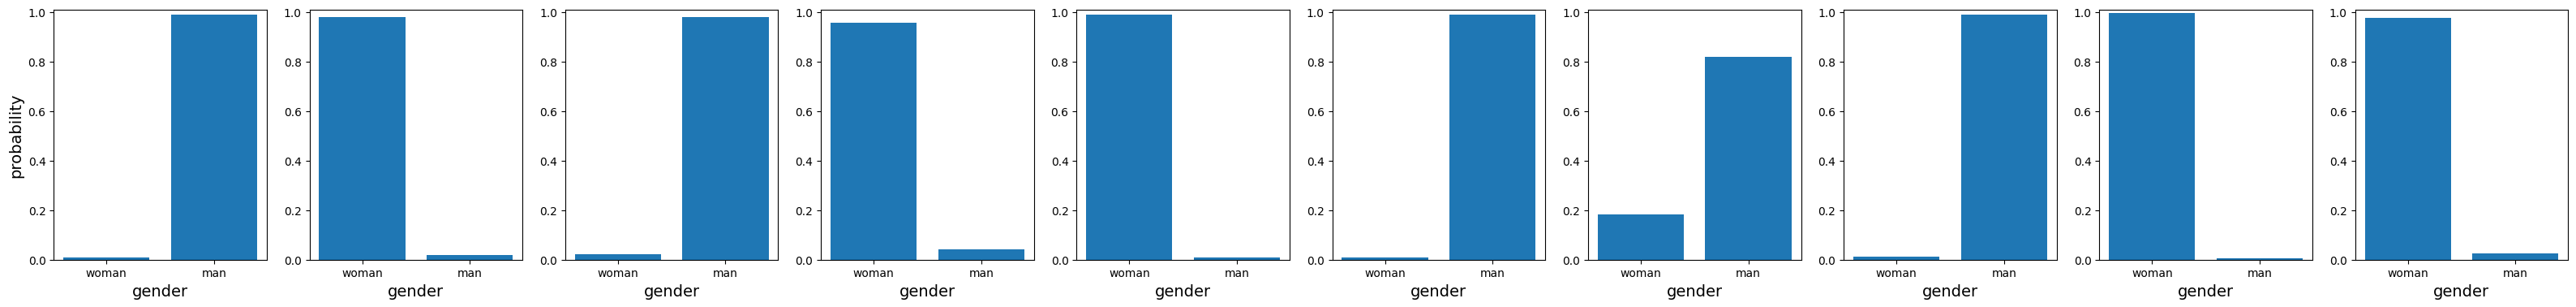

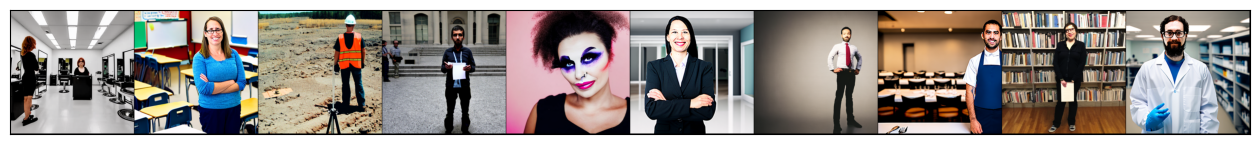

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1


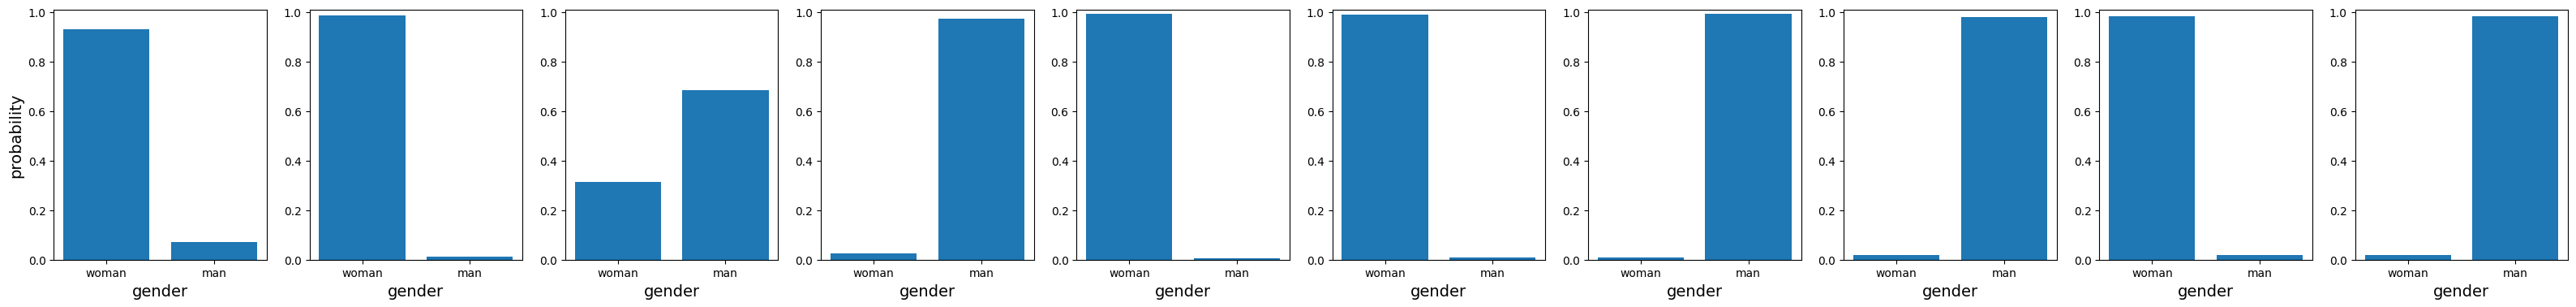

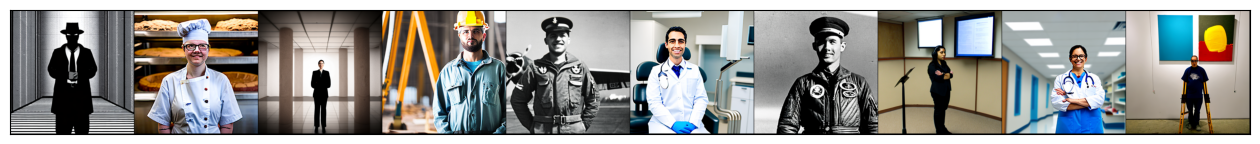

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1


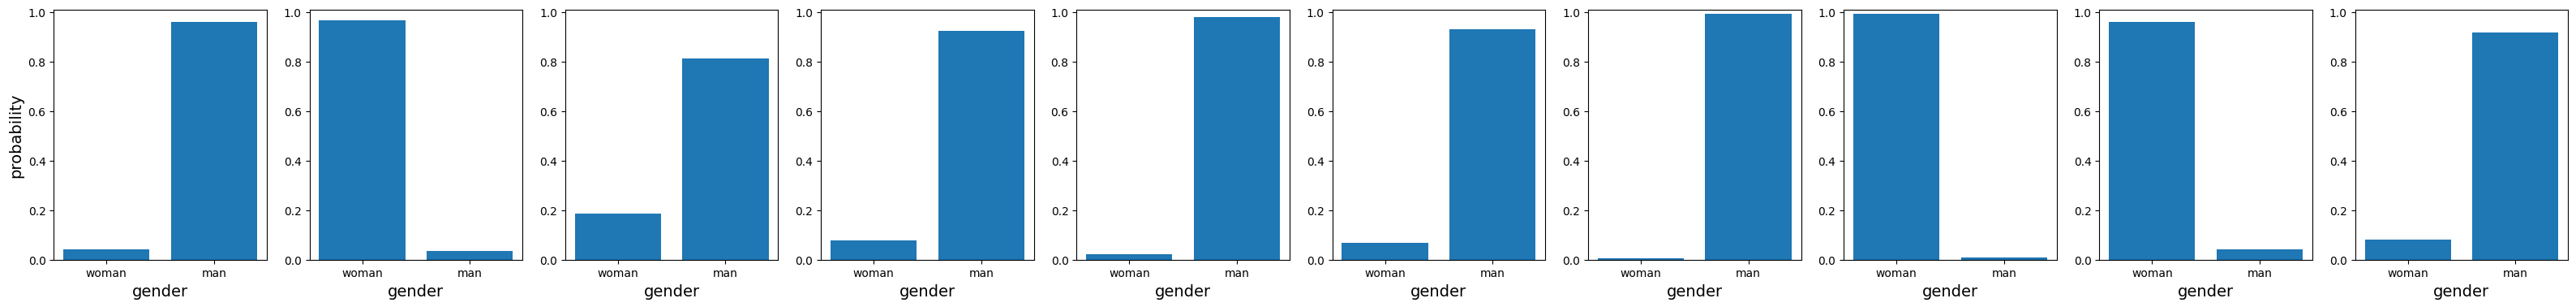

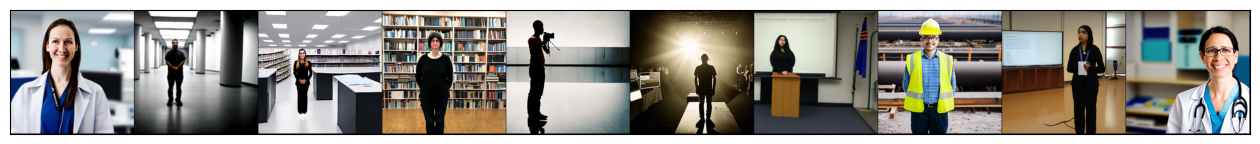

What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 2
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 1
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0
What gender does this photo show? Enter 0 for Female, 1 for Male, 2 for Unsure. 0


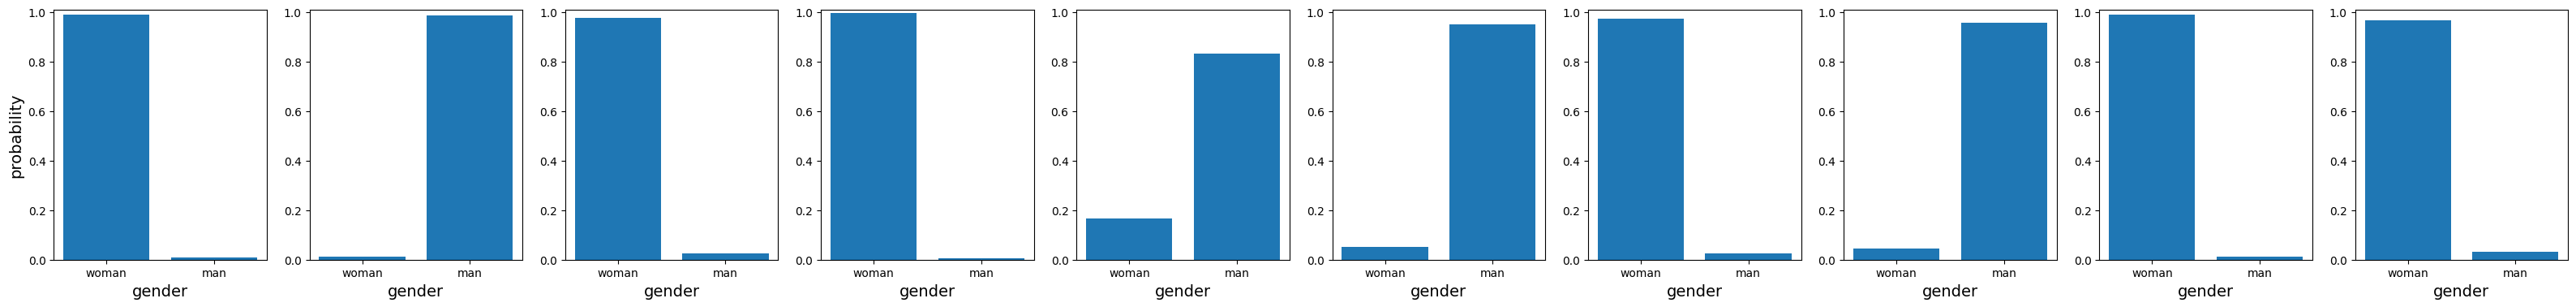

In [15]:
batch_size = 10
cfg_w = 20.0
pred_labels, true_labels = clip_predict(batch_size, cfg_w)

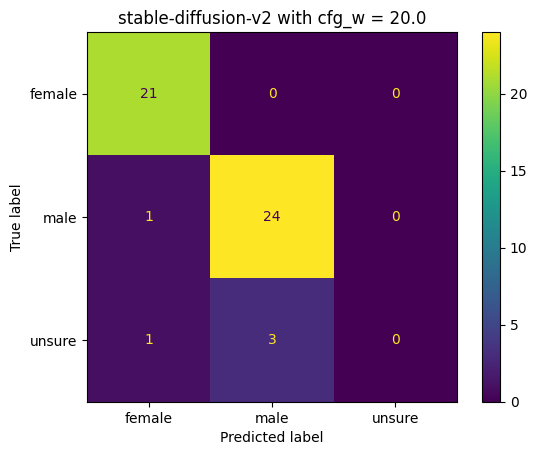

number of automatic classifier predict to be female: 23
number of human perceived annotate to be female: 21
number of human perceived annotate to be unsure: 4


In [16]:
# confusion matrix
plot_cfmx(pred_labels, true_labels, cf_title=f"stable-diffusion-v2 with cfg_w = {cfg_w}")

# consistency at representation level: number of predicted female and numer of labeled female
print(f"number of automatic classifier predict to be female: {sum(pred_labels == 0)}")
print(f"number of human perceived annotate to be female: {sum(true_labels == 0)}")
print(f"number of human perceived annotate to be unsure: {sum(true_labels == 2)}")